# Dask DataFrame

Материалы: 
* Макрушин С.В. Лекция 13: Dask DataFrame
* https://docs.dask.org/en/latest/dataframe.html
* JESSE C. DANIEL. Data Science with Python and Dask. 

## Задачи для совместного разбора

1. Считать данные из файлов в каталоге `accounts`. Содержат ли какие-либо из столбцов пропуски?

2. Подсчитать количество раз, которое то или иное имя встретилось в выборке. Вывести самое часто встречающееся имя.

3. Создать новую колонку, которая является результатом от деления значения `amount` нацело на 100, если `amount` > 100, и нулём в противном случае.

## Лабораторная работа 13

In [81]:
import dask.dataframe as dd
import pandas as pd
import dask.bag as db
import json
import dask
import os
import re

1. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Укажите, что в столбце `submitted` содержатся даты.

In [150]:
data_path = 'C:/Users/nabr9/OneDrive/Documents/recipes_full'
recipes = dd.read_csv(os.path.join(data_path, 'recipes_*.csv'),
                      parse_dates=["submitted"], assume_missing=True); recipes

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
npartitions=16,,,,,,,,
,float64,object,float64,float64,datetime64[ns],float64,object,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


2. Выведите метаинформацию о таблице: `npartitions` и типы столбцов.

In [58]:
print(recipes.npartitions, recipes.dtypes)

16 id                       float64
name                      object
minutes                  float64
contributor_id           float64
submitted         datetime64[ns]
n_steps                  float64
description               object
n_ingredients            float64
dtype: object


3. Выведите на экран 5 первых строк таблицы. Выведите на экран 5 последних строк таблицы. В случае сообщения об ошибки объясните причину и исправьте ошибку.

In [59]:
recipes.head()

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970.0,vant ivoire mickies nothing,33.0,803776.0,2019-08-22,4.0,pat and gina neely and their family own and op...,9.0
1,1089012.0,kremsils mariposa baccala cookies class borage...,23.0,51579.0,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5.0
2,1428572.0,tania lander,0.0,68884.0,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5.0
3,1400250.0,heloise milli asher doogh zojirushi,24.0,678862.0,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1.0
4,387709.0,nutty chocolate chunk cookies,47.0,489552.0,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10.0


In [62]:
len(recipes)

2231637

In [70]:
recipes.partitions[15].tail()

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
44011,1029131.0,tuti waffle snackies steakhouse,19.0,171345.0,1973-10-18,4.0,"according to a providence journal article, ama...",4.0
44012,1700703.0,noelias cheats crocante fleisch zitumbuwa,1.0,30228.0,2007-07-01,6.0,if possible sauté the onions and garlic in abo...,1.0
44013,1910650.0,rubbed restuffed pelmeni bedouin flavourful,60.0,591905.0,2009-09-26,3.0,another great recipe to add to the growing swe...,2.0
44014,713836.0,stems polpettine peezi,NaN,357389.0,2003-09-30,4.0,adapted from top secret recipes. love this!,9.0
44015,660699.0,clementines,64.0,29196.0,1973-06-03,6.0,this would make a great start to your holiday ...,8.0


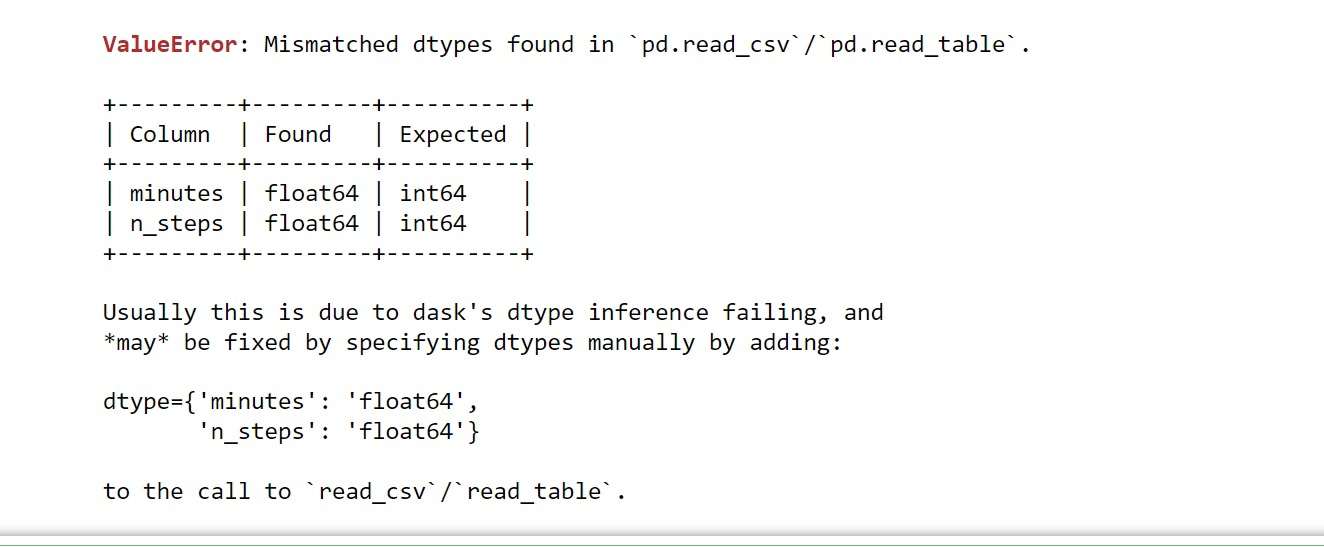

4. Посчитайте, сколько строк содержит каждый из блоков

In [74]:
[len(recipes.partitions[i]) for i in range(1, recipes.npartitions)]

[41450,
 235222,
 43733,
 238139,
 40816,
 234750,
 44205,
 237887,
 41068,
 234486,
 44468,
 238298,
 40656,
 234938,
 44016]

5. Найдите максимум в столбце `n_steps`. Визуализируйте граф вычислений для этой задачи. Прокомментируйте логику работы `dask` в этом случае.

In [76]:
m = recipes['n_steps'].max()

In [146]:
m.compute()

145.0

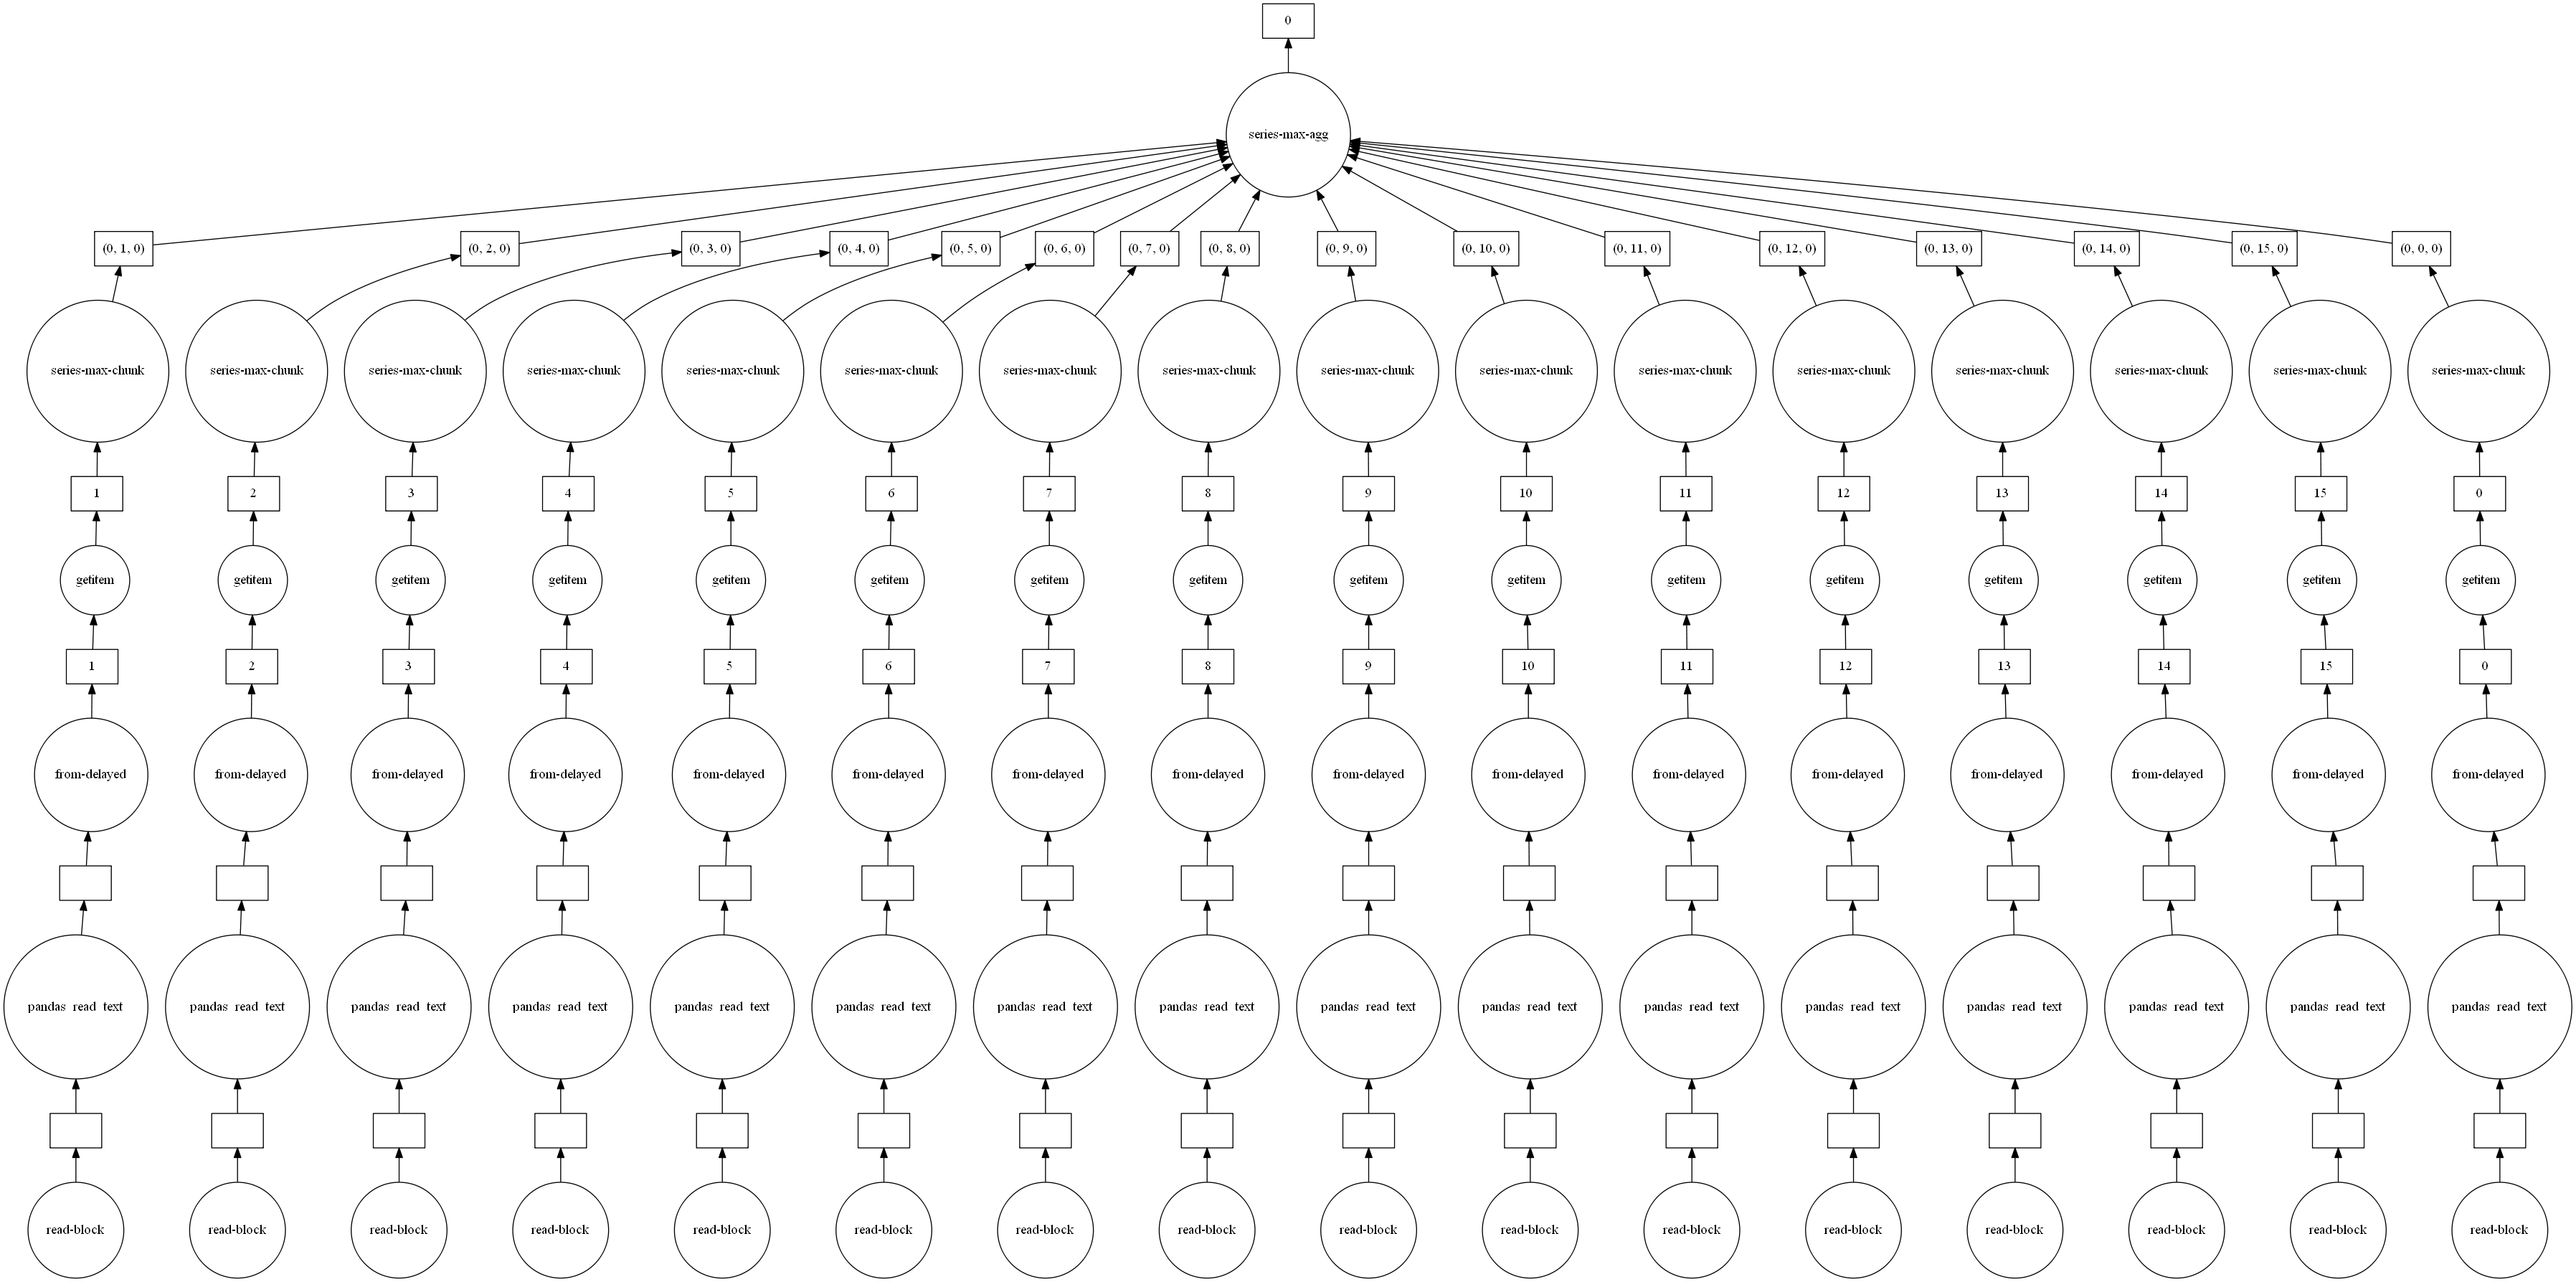

In [77]:
m.visualize()

6. Посчитайте количество отзывов с группировкой по месяцам добавления отзыва в базу.

In [148]:
b = recipes['description'].groupby(recipes['submitted'].map(lambda x: x.month)).count().compute()

In [149]:
b

submitted
1     189401
2     170092
3     187930
4     182235
5     188520
6     180301
7     185465
8     183140
9     177181
10    182843
11    176887
12    179704
Name: description, dtype: int64

7. Считайте файлы из архива `reviews_full.zip` (__ЛР12__) в виде `dask.bag`. Пользуясь результатом лабораторной работы 12, рассчитайте среднее значение оценок отзывов с группировкой по месяцам. После завершения всех вычислений преобразуйте результат к `pd.Series`.

In [87]:
data_path2 = 'C:/Users/nabr9/OneDrive/Documents/reviews_full'

In [88]:
def rating(a):
    rate = int(re.sub('.json', '', re.sub('C:/Users/nabr9/OneDrive/Documents/reviews_full/reviews_', '', a[1])))
    a = json.loads(a[0])
    a.update({'rating': rate})
    return a

In [89]:
b1 = db.read_text(os.path.join(data_path2, 'reviews_*.json'), include_path = True).map(rating)
b1.take(5)

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.',
  'rating': 0},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten',
  'rating': 0},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will

In [118]:
rate = b1.pluck('rating').compute()
datee = b1.pluck('date').compute()

In [119]:
datee = [int(i[5:7]) for i in datee]

In [140]:
d = {'datee': datee, 'rate': rate}
df1 = dd.from_pandas(pd.DataFrame(data=d), npartitions=1)

In [141]:
a = df1['rate'].groupby(df1['datee']).mean().compute()

In [142]:
a

datee
1     4.408553
2     4.407135
3     4.406911
4     4.412259
5     4.415401
6     4.418419
7     4.411717
8     4.410822
9     4.410661
10    4.411452
11    4.408829
12    4.406908
Name: rate, dtype: float64

8. Пользуясь результатами решения задач 6 и 7, создайте `pd.DataFrame`, содержащий два столбца: `mean_rating`, `recipes_count`

In [143]:
d = {'mean_rating': a, 'recipes_count': b}
df2 = dd.from_pandas(pd.DataFrame(data=d), npartitions=1)

In [144]:
df2.head(12)

,mean_rating,recipes_count
1,4.408553,189401
2,4.407135,170092
3,4.406911,187930
4,4.412259,182235
5,4.415401,188520
6,4.418419,180301
7,4.411717,185465
8,4.410822,183140
9,4.410661,177181
10,4.411452,182843
